# Problem Set 6A

In [1]:
import numpy as np
from numba import njit
from matplotlib import pyplot as plt
import statsmodels.api as sm
from IPython.display import Markdown

## 1. Simulation of the Asset Exchange Model

### (a)  Write  a  Python  program  to  simulate  the  asset  exchange  model  with  the  saving  factors  distributed according to
$$
\rho(\lambda)\propto\lambda^{-0.7}, \lambda\in[0,1].
$$
The number of agents $N$ is not less than 1,000.

The number of iterations $T$ is not less than 5,000.

The number of samples $S$ is not less than 5.

The wealth of each agent $m_i(0)$ is initialized to 1.

#### Random saving factors formula

First of all, calculate the formulate to get the random saving factors:

Let $u\sim \mathcal{U}(0,1)$, then $\lambda=F^{-1}(u)=u^{\frac1{0.3}}$.

#### Exchange between agents

$$
\begin{pmatrix}m_i(t+1)\\ m_j(t+1)\end{pmatrix}=
\begin{pmatrix}\lambda_i+\epsilon_{ij}(1-\lambda_i)&\epsilon_{ij}(1-\lambda_j)\\(1-\epsilon_{ij})(1-\lambda_i)&\lambda_j+(1-\epsilon_{ij})(1-\lambda_j)\end{pmatrix}\begin{pmatrix}m_i(t)\\ m_j(t)\end{pmatrix},
$$

where $\epsilon_{ij}\sim\mathcal{U}(0,1)$.


In [2]:
@njit
def asset_exchange_simu(N=1000,T=5000,alpha=-0.7,seed=123456):
    np.random.seed(seed)
    m=np.zeros((N,T+1))
    m[:,0]=np.ones(N)
    λ=np.random.random(N)**(1/(alpha+1))
    for t in range(T):
        pairs=np.random.permutation(N).reshape(-1,2)
        εs=np.random.random(N//2)
        for pair,ε in zip(pairs,εs):
            i,j = pair
            m[i,t+1]=(λ[i]+ε*(1-λ[i]))*m[i,t]+ε*(1-λ[j])*m[j,t]
            m[j,t+1]=(λ[j]+(1-ε)*(1-λ[j]))*m[j,t]+(1-ε)*(1-λ[i])*m[i,t]
    return m

In [3]:
%%time
nsample=8
N=2000
T=10000
wealth=[]
for i in range(nsample):
    wealth.extend(asset_exchange_simu(N=N,T=T,seed=5003+i)[:,-1])

Wall time: 6.73 s


### (b) Construct a histogram of the wealth distribution in log-log scale. 
To facilitate the analysis of the tail distribution, the histogram should be cumulative from the higher end of the wealth. 
Check whether the tail distribution obeys the power law. If so, calculate the exponent.

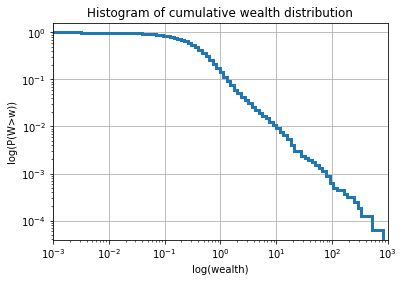

In [4]:
log_wealth=np.log10(wealth)
bins=10**np.linspace(np.min(log_wealth),np.max(log_wealth),101)
plt.title("Histogram of cumulative wealth distribution")
y,x,*_=plt.hist(wealth,bins=bins,density=1,log=True,cumulative=-1,histtype='step',lw=3)
plt.xscale('log')
plt.xlabel("log(wealth)")
plt.ylabel("log(P(W>w))")
plt.xlim([10**-3,10**3])
plt.grid(True)
plt.show()

In [5]:
def fit_tail(x,y):
    X = sm.add_constant(x)
    Y = y

    mod = sm.OLS(Y, X)
    results = mod.fit()
    b,a = results.params
    r2 = results.rsquared
    return a,b,r2

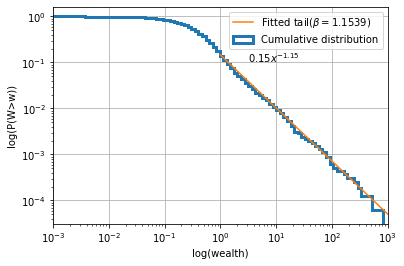

In [6]:
log_wealth=np.log10(wealth)
bins=np.logspace(np.min(log_wealth),np.max(log_wealth),101)
y,x,_=plt.hist(wealth,bins=bins,density=1,log=True,cumulative=-1,histtype='step',lw=3,label="Cumulative distribution")
count=np.sum(x>1)
a,b,r2=fit_tail(np.log10(x[-count:-1]),np.log10(y[-count:-1]))
beta=-a
x=10**np.linspace(0,3)
y_hat=10**b*x**a
plt.plot(x,y_hat,label=rf"Fitted tail($\beta={beta:.4f}$)")
plt.xscale('log')
plt.xlim([10**-3,10**3])
plt.xlabel("log(wealth)")
plt.ylabel("log(P(W>w))")
plt.text(10**0.5,10**-1,rf"${10**b:.2f}x^{{{a:.2f}}}$")
plt.legend()
plt.grid(True)
plt.show()

In [7]:
Markdown(rf"""
The tail distribution $P(W>w) \propto w^{{-\beta}}$ obeys the power law with the exponent $\beta\approx{beta:.4f}$.
""")


The tail distribution $P(W>w) \propto w^{-\beta}$ obeys the power law with the exponent $\beta\approx1.1539$.


### (c) To explain your result to a lay person, you would say that “among the wealthier agents of the model, 
when  we  compare  agents’  wealth  with  those  agents  whose  wealth  is  doubled,  the  average  number  of 
agents will be reduced by a factor of x”. Calculate x.

From aboving tail distribution, we can get CDF of wealth $P(W\leq w)=1-cw^{-\beta}$, 

then the the PDF of wealth is $p(w)=c\beta w^{-1-\beta}$. The average numeber of agents with wealth equals to $w$ is $N\cdot p(w)dw$.

Let denote $W$ as a random variable represents the wealth of a random choosed agent, according to the tail distribution we obtain, $N$ is the total number of agents, so $N\cdot p(w)dw$ is the average number of agents whose wealth equals $w$. Now let's consider the average number of agents whose wealth equals to $2w$ which doubled $w$ is $N\cdot p(2w)dw$. The average number of agents will be reduced by a factor $x=\frac{p(2w)}{p(w)}=2^{-1-\beta}$.

In [8]:
print(f"The estimated reduced factor x is {2**(-1-beta):.4f}.")

The estimated reduced factor x is 0.2247.


### (d)  Construct  a  histogram  of  the  wealth  distribution  in  log-linear  scale  among  the  less  wealthy  agents, 
defined as those agents with final wealth less than the initial wealth. To facilitate the analysis of the tail 
distribution, the histogram should be cumulative from the higher end of the wealth. Check whether the 
tail distribution obeys the exponential law. If so, calculate the exponential function.

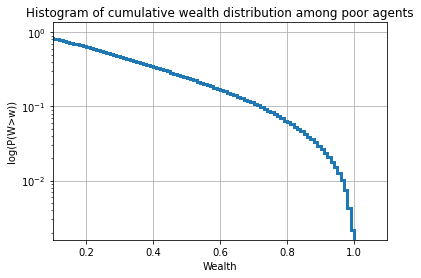

In [9]:
bins=np.linspace(0,1,101)
plt.title("Histogram of cumulative wealth distribution among poor agents")
y,x,*_=plt.hist(wealth,bins=bins,density=1,log=True,cumulative=-1,histtype='step',lw=3)
plt.xlabel("Wealth")
plt.xlim([0.1,1.1])
plt.ylabel("log(P(W>w))")
plt.grid(True)
plt.show()

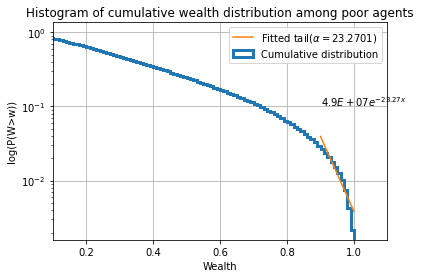

In [10]:
bins=np.linspace(0,1,101)
plt.title("Histogram of cumulative wealth distribution among poor agents")
y,x,*_=plt.hist(wealth,bins=bins,density=1,log=True,cumulative=-1,histtype='step',lw=3,label="Cumulative distribution")
count=np.sum(x>=0.9)
a,b,r2=fit_tail(x[-count:],np.log(y[-count:]))
alpha=-a
x=np.linspace(0.9,1)
y_hat=np.exp(a*x+b)
plt.plot(x,y_hat,label=rf"Fitted tail($\alpha={alpha:.4f}$)")
plt.xlabel("Wealth")
plt.xlim([0.1,1.1])
plt.ylabel("log(P(W>w))")
plt.text(0.9,10**-1,rf"${np.exp(b):.1E}e^{{{a:.2f}x}}$")
plt.grid(True)
plt.legend()
plt.show()

In [11]:
Markdown(rf"""
The tail distribution $P(W>w) \propto e^{{-\alpha x}}$ obeys the exponential law.

The exponential function $P(W>w)={np.exp(b):.1E} e^{{{a:.2f}x}}$.
""")


The tail distribution $P(W>w) \propto e^{-\alpha x}$ obeys the exponential law.

The exponential function $P(W>w)=4.9E+07 e^{-23.27x}$.


### (e) To explain your result to a lay person, you would say that “among the less wealthy agents of the model, 
when we compare the average number of agents with a certain wealth with those whose wealth is higher 
by y (in units of the average wealth of the market), the average number of agents will be reduced by one 
half”. Calculate y.

Let denote the CDF is $P(W\leq w)=1 - c e^{-\alpha w}$, then the PDF is $p(w)=c\alpha e^{-\alpha w}$. So the average number of agents with wealth $w$ equals $N\cdot p(w)dw$.

Let's calculate the average number of agents with wealth equals to $w$ is $N\cdot p(w)dw$.Meanwhil the average number of agents whose wealth is higher 
by y is $N\cdot p(w+y)dw$, then the $x=\frac{p(w+y)}{p(w)}=e^{-\alpha y}$ should be $\frac12$, then we get this equation:
$$
e^{-\alpha y}=2^{-1},
$$
then we can solve it and get $y=\frac{\ln 2}{\alpha}$.


In [12]:
print(f"The estimated y is {np.log(2)/alpha:.4f}.")

The estimated y is 0.0298.


### (f) Calculate the percentage of wealth owned by the wealthiest 20% of the agents in your model. 

In [13]:
richers = np.sort(wealth)[-len(wealth)//5:]
percent = np.sum(richers)/np.sum(wealth)
print(f"In this model, about {100*percent:.0f}% of wealth owned by the wealthiest 20% of the agents in this model.")

In this model, about 77% of wealth owned by the wealthiest 20% of the agents in this model.


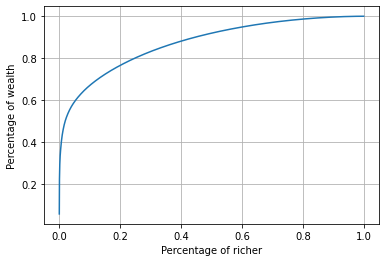

In [14]:
N=len(wealth)
plt.plot(np.arange(N)/N,np.cumsum(np.sort(wealth)[::-1])/np.sum(wealth))
plt.ylabel("Percentage of wealth")
plt.xlabel("Percentage of richer")
plt.grid(True)
plt.show()